## Modeling of Acoustic Scattering by a Cylindrical Obstacle in an Infinite Domain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scat_circ import u_exact_calc, plot_displacement_amplitude, plot_mesh, measure_execution_time, process_onelab_data, plot_fem_results

- $ r_i$: Inner radius [m].
- $ r_e$: Outer radius [m].
- $ r_a$: Radius of the outermost layer [m].
- $ k$: Wave number [a.u.].

In [2]:
r_i = 1.0 # Inner radius
r_e = 10.0 # Outer radius
r_a = 11 # Radius of the outermost layer
k = 1.0  # Wave number
n_grid = 501 # Number of grid points  

### Analytical Solution

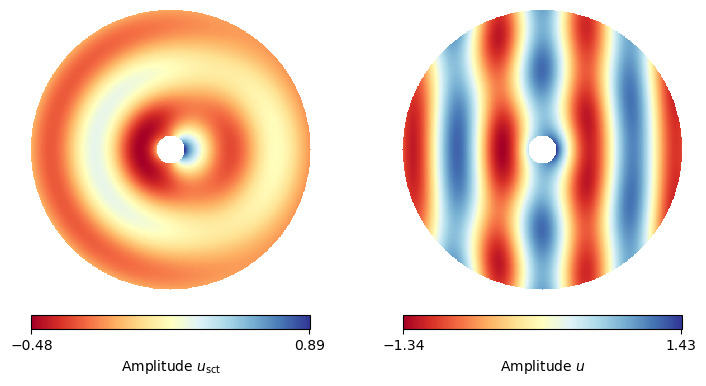

In [3]:
# Create meshgrid for r and theta
Y_exact, X_exact = np.mgrid[-r_e:r_e:n_grid*1j, -r_e:r_e:n_grid*1j] 
R_exact = np.sqrt(X_exact**2 + Y_exact**2) 
Theta_exact = np.arctan2(Y_exact, X_exact)

# Calculate the displacement
u_scn_amp_exact, u_amp_exact = u_exact_calc(R_exact, Theta_exact, r_i, k)  # Calculate the displacement

# Mask out regions where r < r_i (inside the circle with radius r_i) and r > r_e (outside the circle with radius r_e)
u_scn_amp_exact = -np.ma.masked_where((R_exact < r_i) | (R_exact > r_e), u_scn_amp_exact)
u_amp_exact = -np.ma.masked_where((R_exact < r_i) | (R_exact > r_e), u_amp_exact) 

# Plot the displacement amplitude
plot_displacement_amplitude(X_exact, Y_exact, u_scn_amp_exact, u_amp_exact)

### Finite Element Method (FEM)

#### Mesh

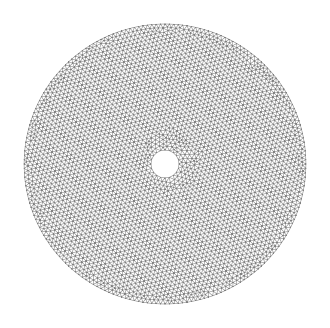

In [4]:
# data mesh
file_path_msh = "AcousticScattering/scattering.msh"

# Plot the mesh
plot_mesh(file_path_msh)

#### Finite elements method (FEM) solution

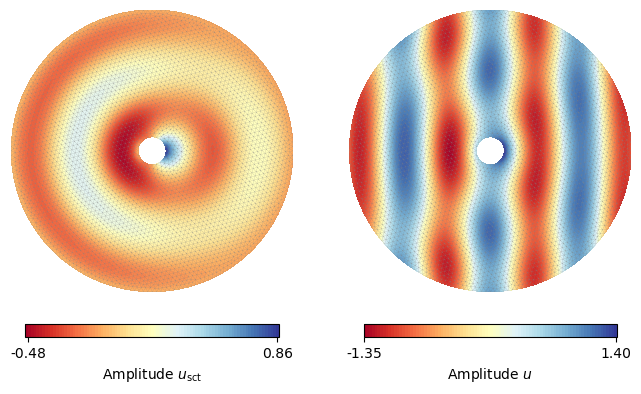

In [2]:
# data u_scn
file_path_u_scn = "AcousticScattering/u.pos"
X_fem, Y_fem, elements_fem, uscn_amp_fem = process_onelab_data(file_path_u_scn)

# data u
file_path_u = "AcousticScattering/u_Total.pos"
_, _, _, u_amp_fem = process_onelab_data(file_path_u)

# Call the function with the appropriate variables
plot_fem_results(X_fem, Y_fem, elements_fem, uscn_amp_fem, u_amp_fem)

#### Accuracy

#### Computation time

In [6]:
# Define the path to the getdp executable (this can be changed per machine)
getdp_path = "/home/orincon/onelab-Linux64/getdp"

# Define the rest of the command arguments
command_args = "AcousticScattering/scattering.pro -solve Scattering -pos Wave -v2"

# Number of runs to measure statistically
num_runs = 10  # You can change this based on how many runs you want

# Example usage
average_time, std_dev_time, min_time, max_time = measure_execution_time(getdp_path, command_args, num_runs)
print(f"Statistical Measurement of Execution Time (over {num_runs} runs):")
print(f"Average Time: {average_time:.2f} seconds")
print(f"Standard Deviation: {std_dev_time:.2f} seconds")
print(f"Minimum Time: {min_time:.2f} seconds")
print(f"Maximum Time: {max_time:.2f} seconds")

Statistical Measurement of Execution Time (over 10 runs):
Average Time: 0.45 seconds
Standard Deviation: 0.03 seconds
Minimum Time: 0.41 seconds
Maximum Time: 0.50 seconds


### Physics informed neural networks (PINNs)